# German Credit Risk Analysis Notebook

This notebook implements the full workflow for analyzing and modeling credit risk using the German Credit dataset. It covers:

1. Data loading and initial checks  
2. Data preprocessing and missing value handling  
3. Exploratory Data Analysis (EDA) visualizations  
4. Feature engineering and train/test split  
5. Model comparison via cross-validation  
6. Hyperparameter tuning for Random Forest  
7. Final evaluation on the test set  
8. Model interpretation and feature importances  


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, confusion_matrix, classification_report)
import lightgbm as lgb
import warnings

# Suppress warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Configuration
DATA_PATH = '/content/german_credit_data.csv'
TARGET_COLUMN = 'Risk'
GOOD_RISK_LABEL_ORIGINAL = 1
BAD_RISK_LABEL_ORIGINAL = 2
GOOD_RISK_LABEL_MAPPED = 1
BAD_RISK_LABEL_MAPPED = 0


In [2]:
# 1. Load Data
try:
    df = pd.read_csv(DATA_PATH, index_col=0, na_values=['NA'])
    print("Data Loaded with index_col=0. Shape:", df.shape)
    if df.index.name is None or 'Unnamed' in str(df.index.name):
        print("Index appears unnamed. Re-loading without index_col.")
        df = pd.read_csv(DATA_PATH, na_values=['NA'])
        print("Reloaded Shape:", df.shape)
except FileNotFoundError:
    raise FileNotFoundError(f"Data file not found at {DATA_PATH}. Please upload it.")

print("\nInitial Data Info:")
df.info()

# Initial target distribution
print(f"\nOriginal '{TARGET_COLUMN}' Value Counts:")
print(df[TARGET_COLUMN].value_counts())


Data Loaded with index_col=0. Shape: (1000, 10)
Index appears unnamed. Re-loading without index_col.
Reloaded Shape: (1000, 11)

Initial Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Unnamed: 0        1000 non-null   int64 
 1   Age               1000 non-null   int64 
 2   Sex               1000 non-null   object
 3   Job               1000 non-null   int64 
 4   Housing           1000 non-null   object
 5   Saving accounts   817 non-null    object
 6   Checking account  606 non-null    object
 7   Credit amount     1000 non-null   int64 
 8   Duration          1000 non-null   int64 
 9   Purpose           1000 non-null   object
 10  Risk              1000 non-null   int64 
dtypes: int64(6), object(5)
memory usage: 86.1+ KB

Original 'Risk' Value Counts:
Risk
1    722
2    278
Name: count, dtype: int64



Mapped 'Risk' (0=Bad, 1=Good):
Risk
1    722
0    278
Name: count, dtype: int64 

Class Distribution (%):
Risk
1    72.2
0    27.8
Name: proportion, dtype: float64

Missing values before handling:
Unnamed: 0            0
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

Missing values after handling:
Unnamed: 0          0
Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
Risk                0
dtype: int64


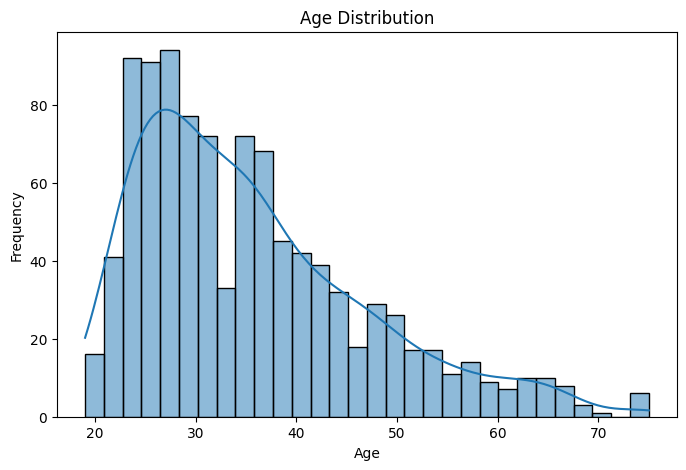

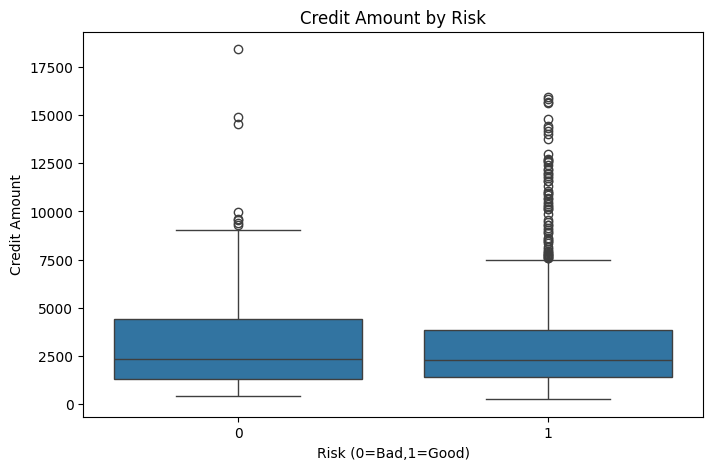

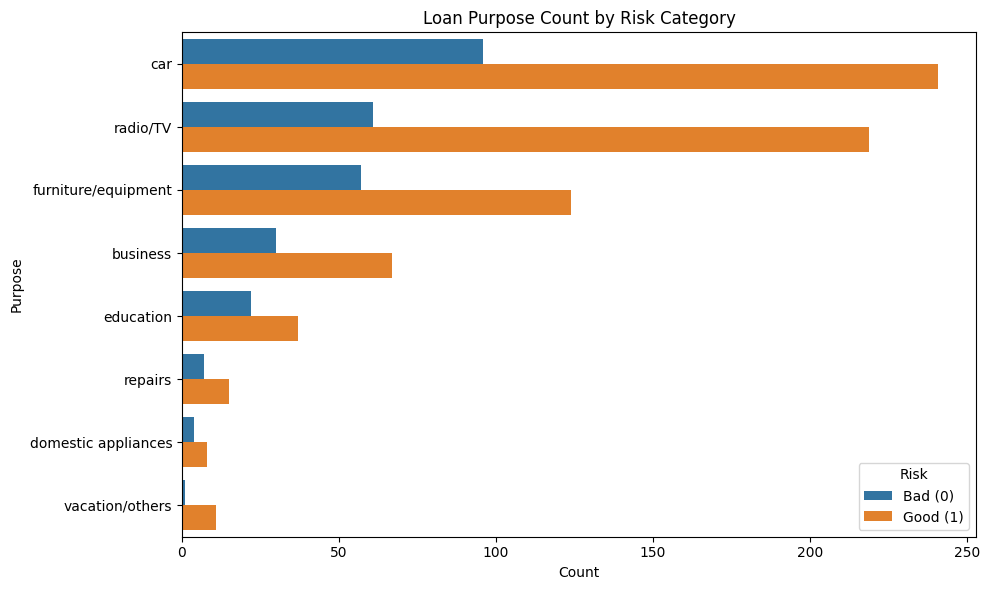

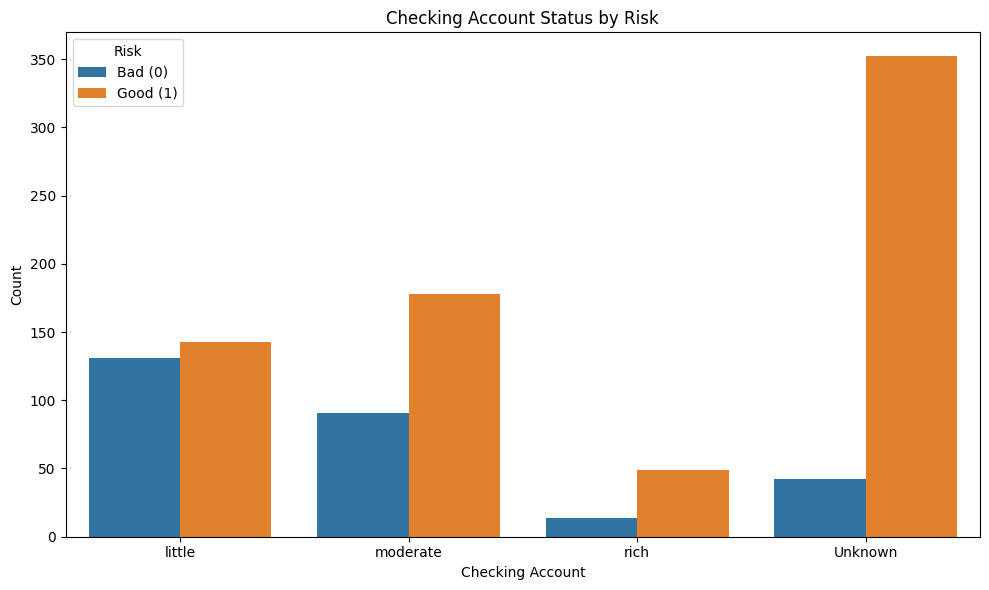

In [3]:
# 2. Data Preprocessing & EDA

# Map target labels
df[TARGET_COLUMN] = df[TARGET_COLUMN].apply(
    lambda x: GOOD_RISK_LABEL_MAPPED if x == GOOD_RISK_LABEL_ORIGINAL else BAD_RISK_LABEL_MAPPED
)
print(f"\nMapped '{TARGET_COLUMN}' (0=Bad, 1=Good):")
print(df[TARGET_COLUMN].value_counts(), "\n")
print("Class Distribution (%):")
print((df[TARGET_COLUMN].value_counts(normalize=True) * 100).round(2))

# Missing values
print("\nMissing values before handling:")
print(df.isnull().sum())
df['Saving accounts'].fillna('Unknown', inplace=True)
df['Checking account'].fillna('Unknown', inplace=True)
print("\nMissing values after handling:")
print(df.isnull().sum())

# EDA Visualizations
plt.figure(figsize=(8,5))
sns.histplot(df['Age'], kde=True, bins=30)
plt.title('Age Distribution')
plt.xlabel('Age'); plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(8,5))
sns.boxplot(x=TARGET_COLUMN, y='Credit amount', data=df)
plt.title('Credit Amount by Risk')
plt.xlabel('Risk (0=Bad,1=Good)'); plt.ylabel('Credit Amount')
plt.show()

plt.figure(figsize=(10,6))
sns.countplot(y='Purpose', hue=TARGET_COLUMN, data=df, order=df['Purpose'].value_counts().index)
plt.title('Loan Purpose Count by Risk Category')
plt.xlabel('Count'); plt.ylabel('Purpose')
plt.legend(title='Risk', labels=['Bad (0)','Good (1)'])
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
sns.countplot(x='Checking account', hue=TARGET_COLUMN, data=df,
              order=['little','moderate','rich','Unknown'])
plt.title('Checking Account Status by Risk')
plt.xlabel('Checking Account'); plt.ylabel('Count')
plt.legend(title='Risk', labels=['Bad (0)','Good (1)'])
plt.tight_layout()
plt.show()


In [4]:
# 3. Feature Engineering & Split

# Identify feature types
numerical_features = df.select_dtypes(include=np.number).columns.tolist()
categorical_features = df.select_dtypes(include='object').columns.tolist()

# Move 'Job' to categorical if present
if 'Job' in numerical_features:
    numerical_features.remove('Job')
    categorical_features.append('Job')
    df['Job'] = df['Job'].astype(str)

# Exclude target
if TARGET_COLUMN in numerical_features: numerical_features.remove(TARGET_COLUMN)
if TARGET_COLUMN in categorical_features: categorical_features.remove(TARGET_COLUMN)

print("\nNumerical Features:", numerical_features)
print("Categorical Features:", categorical_features)

# Train-test split
X = df.drop(TARGET_COLUMN, axis=1)
y = df[TARGET_COLUMN]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)
print("\nTrain shapes:", X_train.shape, y_train.shape)
print("Test shapes: ", X_test.shape, y_test.shape)

# Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), categorical_features)
], remainder='passthrough')



Numerical Features: ['Unnamed: 0', 'Age', 'Credit amount', 'Duration']
Categorical Features: ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Job']

Train shapes: (750, 10) (750,)
Test shapes:  (250, 10) (250,)


In [5]:
# 4. Model Comparison & Hyperparameter Tuning

models = {
    'Logistic Regression': LogisticRegression(random_state=42, solver='liblinear',
                                              class_weight='balanced', max_iter=1000),
    'Random Forest': RandomForestClassifier(random_state=42,
                                            class_weight='balanced', n_jobs=-1),
    'LightGBM': lgb.LGBMClassifier(random_state=42,
                                   class_weight='balanced', n_jobs=-1, verbosity=-1)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}
print("\nCross-Validation ROC AUC scores:")
for name, model in models.items():
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('classifier', model)])
    scores = cross_val_score(pipeline, X_train, y_train, cv=cv,
                             scoring='roc_auc', n_jobs=-1)
    results[name] = scores
    print(f"{name}: {scores.mean():.4f} ± {scores.std():.4f}")

# Best initial model
best_init = max(results, key=lambda k: results[k].mean())
print(f"\nBest initial model: {best_init}")

# Hyperparameter tuning for Random Forest
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(
                                  random_state=42, class_weight='balanced', n_jobs=-1))])

param_grid_rf = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [10, 20, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 3, 5]
}

grid_search_rf = GridSearchCV(rf_pipeline, param_grid_rf, cv=cv,
                              scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train, y_train)

print("\nBest RF parameters:", grid_search_rf.best_params_)
print("Best RF ROC AUC:", grid_search_rf.best_score_)
final_model = grid_search_rf.best_estimator_



Cross-Validation ROC AUC scores:
Logistic Regression: 0.7299 ± 0.0662
Random Forest: 0.6933 ± 0.0615
LightGBM: 0.7033 ± 0.0497

Best initial model: Logistic Regression
Fitting 5 folds for each of 81 candidates, totalling 405 fits

Best RF parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 100}
Best RF ROC AUC: 0.7279230268638786



Test Set Evaluation:
Accuracy : 0.764
Precision: 0.8315217391304348
Recall   : 0.8453038674033149
F1-score : 0.8383561643835616
ROC AUC  : 0.7758827768436225

Classification Report:
              precision    recall  f1-score   support

     Bad (0)       0.58      0.55      0.56        69
    Good (1)       0.83      0.85      0.84       181

    accuracy                           0.76       250
   macro avg       0.70      0.70      0.70       250
weighted avg       0.76      0.76      0.76       250



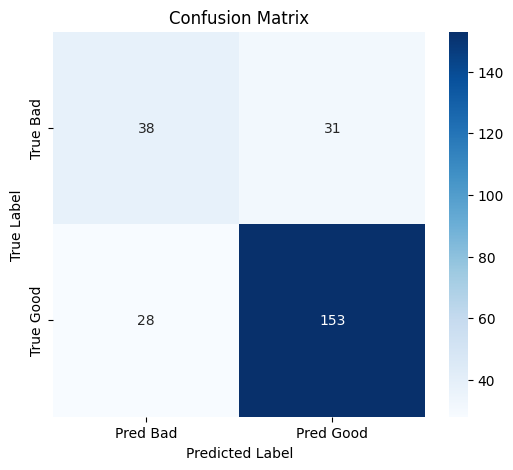


Top 15 Features by Importance:
                        Feature  Importance
2                 Credit amount    0.143059
11      Checking account_little    0.139659
0                    Unnamed: 0    0.138371
1                           Age    0.130220
3                      Duration    0.125022
7        Saving accounts_little    0.047715
12    Checking account_moderate    0.045589
5                   Housing_own    0.026278
14                  Purpose_car    0.024906
18             Purpose_radio/TV    0.022526
4                      Sex_male    0.021962
22                        Job_2    0.020252
10         Saving accounts_rich    0.018301
17  Purpose_furniture/equipment    0.016686
23                        Job_3    0.015926


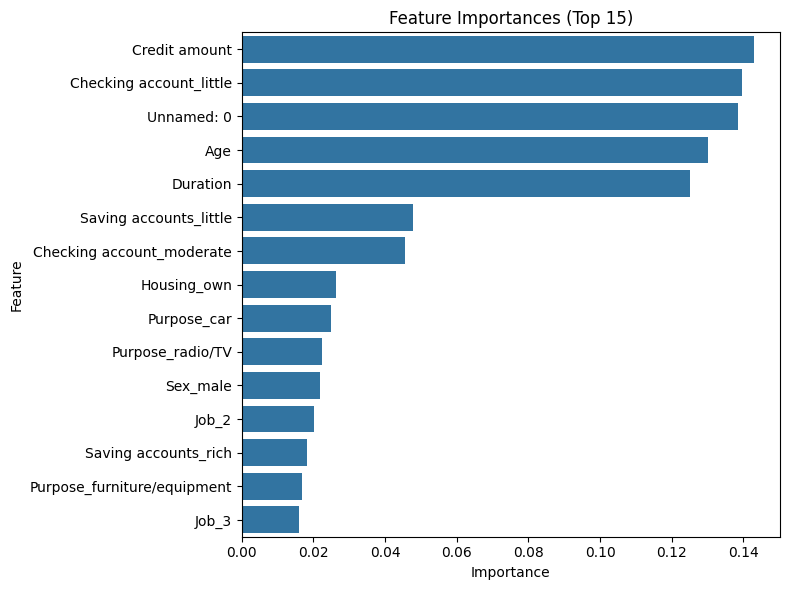

In [6]:
# 5. Final Evaluation & Interpretation

# Predictions
y_pred = final_model.predict(X_test)
y_proba = final_model.predict_proba(X_test)[:,1]

# Metrics
print("\nTest Set Evaluation:")
print("Accuracy :", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall   :", recall_score(y_test, y_pred))
print("F1-score :", f1_score(y_test, y_pred))
print("ROC AUC  :", roc_auc_score(y_test, y_proba))

# Classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Bad (0)','Good (1)']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Pred Bad','Pred Good'],
            yticklabels=['True Bad','True Good'])
plt.title('Confusion Matrix')
plt.ylabel('True Label'); plt.xlabel('Predicted Label')
plt.show()

# Feature importances
clf = final_model.named_steps['classifier']
encoder = final_model.named_steps['preprocessor'].named_transformers_['cat']
feature_names = numerical_features + encoder.get_feature_names_out(categorical_features).tolist()

importances = (clf.feature_importances_
               if hasattr(clf, 'feature_importances_')
               else np.abs(clf.coef_[0]))
feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(15)

print("\nTop 15 Features by Importance:")
print(feat_imp_df)

plt.figure(figsize=(8,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
plt.title('Feature Importances (Top 15)')
plt.tight_layout()
plt.show()
